Exercise 11: Low-rank approximations in the Ising model
====================================
<img src="ising.png" style="max-width:30%; float:right; padding-left:30pt">

Let us return to our study of the [Ising model]. As reminder: the Ising model is a $N \times N$
(in our case `40 x 40`) square grid of Ising spins, $\sigma_{i,j}$, which can either be $+1$ or $-1$
at any given moment.  The potential energy $U$ encoded in each configuration is given by:
$$
   U = -\sum_{i,j} \big[ \sigma_{i,j} \sigma_{i,j+1} + \sigma_{i,j} \sigma_{i+1,j} \big],
$$
which is competing with the kinetic energy due to temperature $T$, which is randomly flipping spins.

The dataset is almost the same as for the last exercise, but I have split it by temperature: there
are $N_T = 10$ temperatures, $T = 0.25, 0.5, \ldots, 3.75$, stored in the array `temp`.
For each temperature, there are $N = 16000$
observations, so the `spins` tensor is now of shape $N_T \times N \times L \times L$.

The idea of this lecture is to explore different low-rank approximations to this tensor.

[Ising model]: https://en.wikipedia.org/wiki/Ising_model


In [365]:
import numpy as np
import os
import matplotlib.pyplot as pl

In [366]:
# Load the dataset from a binary file
with np.load(os.path.expanduser("~/shared/ising.npz")) as _datafile:
    spins = _datafile["spins"].reshape(10, 16_000, 40, 40)
    temp = _datafile["temp"][::16_000]

In [367]:
spins.shape

(10, 16000, 40, 40)

In [368]:
temp

array([0.25, 0.5 , 1.  , 1.25, 1.75, 2.25, 2.5 , 3.  , 3.25, 3.75])

In [369]:
temp.shape

(10,)

Part 1. Compressing the design matrix for low T
--------------------------------
First, let us analyze the singular value decomposition of the "design matrices" $X$
for each temperature.

For this, make a new tensor `X`, which contains all 10 temperatures.  It should "flatten" out the
grid of spins into a single dimension.  In other words, the spins are the features in our design
matrix.

Also, restrict yourself to the first 1,000 observations in each temperature (otherwise the SVD will
become too expensive)

In [370]:
# spins.shape[:-2] keeps the first two dimensions unchanged
# adding the -1 in the third dimension makes numpy figure out how to squeeze all the remaining data into it
X = spins.reshape(spins.shape[:-2] + (-1,))[:,:1000,:]

In [371]:
X.shape

(10, 1000, 1600)

In [372]:
assert X.shape == (10, 1000, 1600)


Perform a **thin SVD** of the design matrix for $T = 1.75$.
Plot the singular values on a logarithmic scale.

Reminder: thin SVDs can be computed by passing `full_matrices=False`.

In [373]:
X_T175 = X[np.where(temp == 1.75)[0][0],:,:]
U, S, VT = np.linalg.svd(X_T175, full_matrices=False);

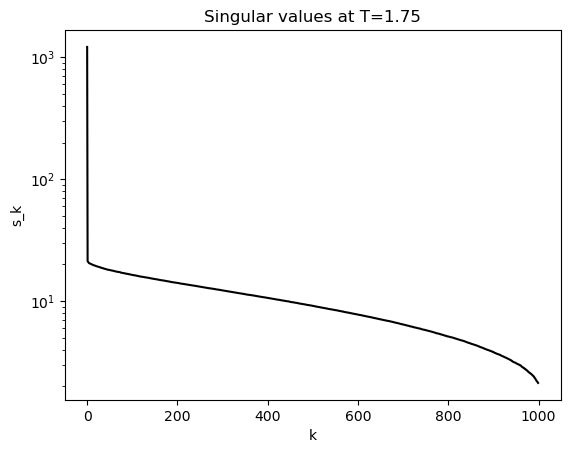

In [374]:
pl.plot(S, c="k")

pl.ylabel(r"s_k")
pl.xlabel("k")
pl.title("Singular values at T=1.75")
pl.yscale("log")

Let us now do a truncated SVD approximation: 
$$ 
\hat X_K = \sum_{k=0}^{K-1} s_k \vec u_k \vec v_k^T
$$
with $K = 1$ (rank-1 approximation). Compute this approximation and store it in `X1`.

Also, infer the relative error of this approximation
$$
    \epsilon_1 = \frac{\Vert X - \hat X_1\Vert}{\Vert X\Vert}
$$
and print it.  Compute this quantity **only** from the singular values.

In [375]:
def truncSVD(K,S,U,VT):    
    return (U[:,:K] * S[:K]) @ VT[:K,:]
        
X1 = truncSVD(1, S, U, V)

# First discarded singular value / first singular value
epsilon1 = S[1] / S[0]
epsilon1

0.01743500732980052

In [376]:
assert X1.shape == (1000, 1600)
assert np.allclose(X1 / X1[:1], X1[:,:1] / X1[0,0]), "not rank-1"
assert np.allclose(X1 / X1[:,:1], X1[:1] / X1[0,0]), "not rank-1"

Let us now analyze this approximation visually. Make a figure with three false color plots
as subplots, showing the following:

 1. the actual design matrix $X$
 2. the rank-1 approximation $\hat X_1$
 3. the difference: $\tfrac12 (X - \hat X_1)$. (the one-half is there so that the result is again in the range $[-1,1]$).
 
Add titles and a colorbar (include a label for the colorbar too).

Hint: I find plotting this with the `'binary'` colormap gives a most appealing picture, but you can use any one.

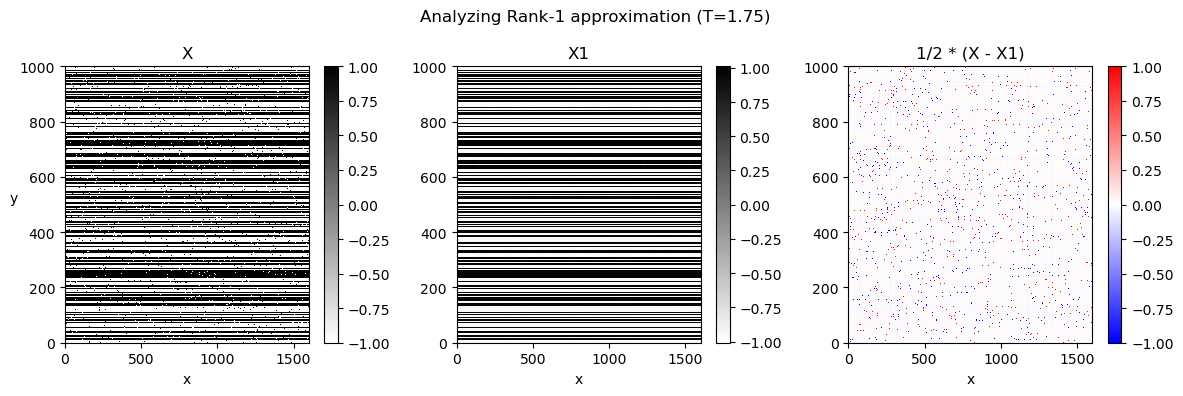

In [377]:

def plotComparison(A, B, tA, tB, tC, T):
    # Create a figure with three subplots
    fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Plot the first subplot
    axes[0].pcolormesh(A, cmap='binary')
    axes[0].set_title(tA)

    # Plot the second subplot
    axes[1].pcolormesh(B, cmap='binary')
    axes[1].set_title(tB)

    # Plot the third subplot
    axes[2].pcolormesh(0.5*(A - B), vmax=1, vmin=-1, cmap='bwr')
    axes[2].set_title(tC)

    # Add a colorbar to each subplot
    cbar1 = fig.colorbar(axes[0].collections[0], ax=axes[0])
    cbar2 = fig.colorbar(axes[1].collections[0], ax=axes[1])
    cbar3 = fig.colorbar(axes[2].collections[0], ax=axes[2])
    
    # set axislabels    
    axes[0].set_ylabel('y', rotation=0)
    for ax in axes:
        ax.set_xlabel('x')

        
    # Set the overall title for the figure
    fig.suptitle(T)

    # Adjust the spacing between subplots
    pl.tight_layout()
    
plotComparison(X_T175, X1, 'X', 'X1', '1/2 * (X - X1)', 'Analyzing Rank-1 approximation (T=1.75)')

Let us analyze these plots:

 1. Observe the data $X$ mostly consists of "stripes".  Translate these back to our field
    of Ising spins: what does these stripes correspond to?  How is this related to
    the chosen temperature? (Hint: think about the last exercise)
    
 2. Now lets talk about the model $\hat X_1$. How do the dominant left ($u_k$) and right ($v_k$) 
    singular vector relate to the spin configurations?
    
 3. Using the previous points, explain why the model has such a good performance in this case.
    What is "missing"?

YOUR ANSWER HERE

Part 2. Compressing the design matrix for higher T
----------------------------------------
Let us redo our analysis for $T = 2.5$.

Again perform a singular value decomposition of the design matrix $X$ for $T = 2.5$.
(You may want to use different variables for the result of the SVD).

Make a plot with two lines, one for the previous case ($T = 1.75$), one for this case.
In both cases plot the **normalized** singular values $s_k/s_0$ on a log scale.

Observe the very different behaviour.  Also, print the relative error
of a rank-1 approximation.

In [378]:
X_T250 = X[np.where(temp == 2.5)[0][0],:,:]
U2, S2, VT2 = np.linalg.svd(X_T250, full_matrices=False);

Text(0.5, 1.0, 'Singular values at T=1.75')

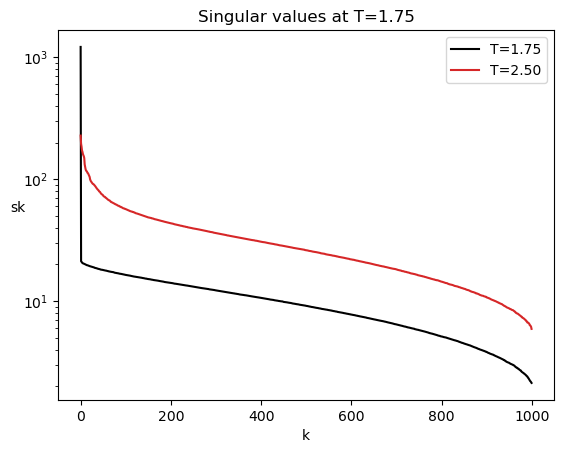

In [379]:
pl.plot(S, c="k", label="T=1.75")
pl.plot(S2, c='C3', label="T=2.50")

pl.yscale("log")

pl.legend()
pl.ylabel("sk", rotation=0)
pl.xlabel("k")
pl.title("Singular values at T=1.75")


Since a rank-1 approximation is so poor, let us construct a **rank-10**
approxiamtion $\hat X_{10}$ to this higher temperature case.
Store this approximation in `Xhat`.

Afterwards, repeat the false color plot with the three panels of data, model
and difference in this case.

In [380]:
Xhat = truncSVD(10, S2, U2, VT2)

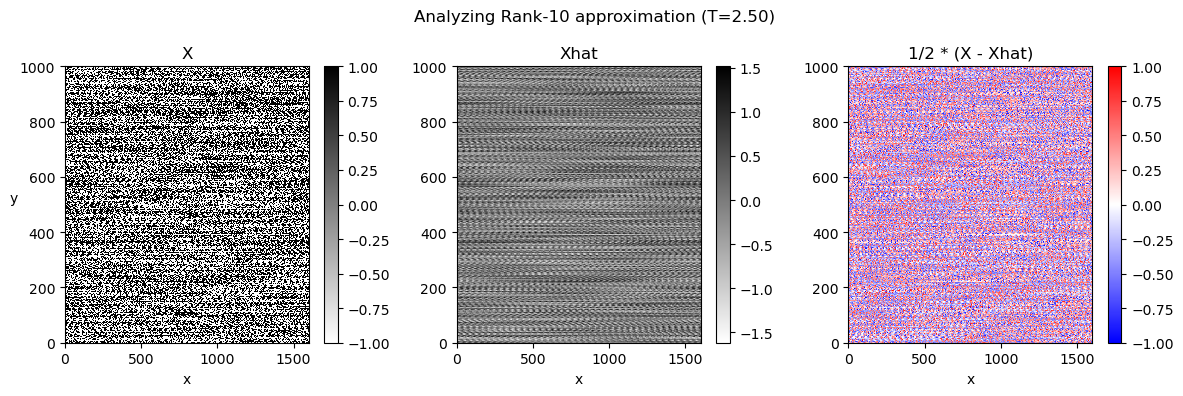

In [381]:
plotComparison(X_T250, Xhat, 'X', 'Xhat', '1/2 * (X - Xhat)', 'Analyzing Rank-10 approximation (T=2.50)')

Let us analyze the data:

 1. First, compare the data to the low-temperature case above. What changed?

 2. Think of the data $X$ (first panel) as the sum of model plus difference (other panels).
    Which qualitative features of the data are captured by the model, and what mainly is "left over"?
    
 3. Observe that the singular values of $X$ decay very differently in the case of
    the ordered phase and the disordered phase.  Discuss the implications of this
    for "compressing" the data.  Use it to resolve the following apparent contradiction: 
    **"Randomness is information"**.
    

YOUR ANSWER HERE

Part 3: Principal Component Analysis
------------------------------------------------

Finally, let us perform a Principal Component Analysis (PCA).
For this, we are going to use sklearn again, specifically the [PCA]
class.

Use the design matrix for $T = 1.75$ and perform a PCA with two
components.

[PCA]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [382]:
import sklearn.decomposition

In [383]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(X_T175);

Reduce the design matrix $X$ to the principal space $\tilde X = X W$
and store it in `Xred`. Now the two features left (i.e., the two columns
of `Xred`) correspond to the two "dominant" features, also known as
*principal components*.

**Hint**: The matrix $W^T$ is is stored as `components_` in the PCA class. Note the transpose!

In [384]:
Xred = X_T175 @ pca.components_.T

In [385]:
assert Xred.shape == (1000, 2)
np.testing.assert_allclose(
    np.linalg.svd(Xred, compute_uv=False), [1220, 21], rtol=3e-1)

Let's analyze our principal components in `Xred`.

Make a 2D scatter plot, where each observation is again a point,
the first component refers to the first principal component and
the second component to the second principal component.

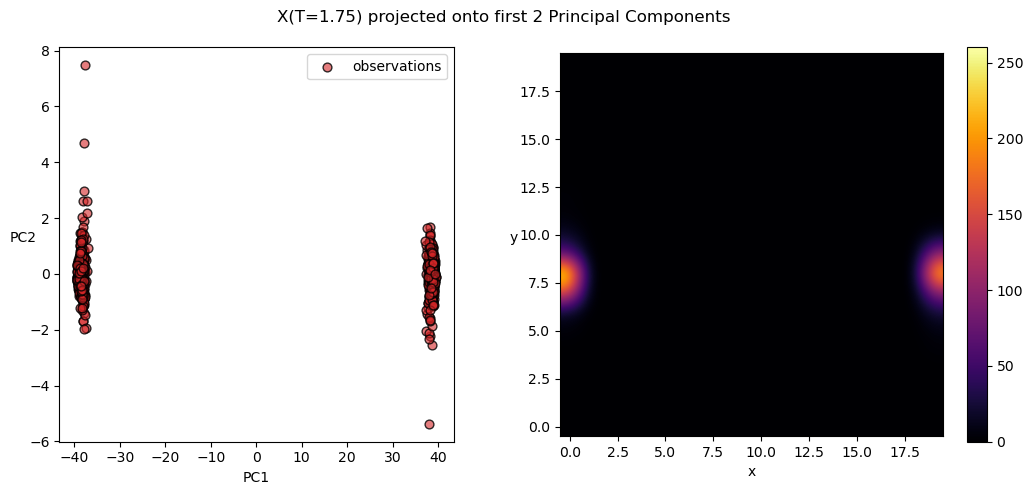

In [567]:
def plot_PCA_projection(Xred, T):
    # Create a figure with three subplots
    fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(11, 5))

    # Scatter Plot
    axes[0].scatter(Xred[:,0], Xred[:,1], s=40, facecolor=(214/256, 39/256, 40/256, 0.6), edgecolor=(0,0,0,0.8), label='observations')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2', rotation=0)
    axes[0].legend()
    axes[0].set_aspect(1.0/axes[0].get_data_ratio(), adjustable='box')

    # Heatmap
    heatmap, xedges, yedges = np.histogram2d(Xred[:,0], Xred[:,1], bins=20)
    im = axes[1].imshow(heatmap.T, origin='lower', cmap='inferno', interpolation='bicubic')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y', rotation=0)
    cbar = fig.colorbar(im, ax=axes[1])
    
    # Set the overall title for the figure
    fig.suptitle(T)

    # Adjust the spacing between subplots
    pl.tight_layout()
    
plot_PCA_projection(Xred, 'X(T=1.75) projected onto first 2 Principal Components')

Copy the previous two answers, i.e., the computation of `Xred` and the plot, from above, 
but alter it as follows: instead of projecting the results for $T = 1.75$ on
its own principal components, see what happens if you project the design matrix `X` for $T = 3.75$
(the highest temperature) onto the principal components for $T = 1.75$.

In other words, **do not** recompute the PCA, just redo the projection
and the plot.

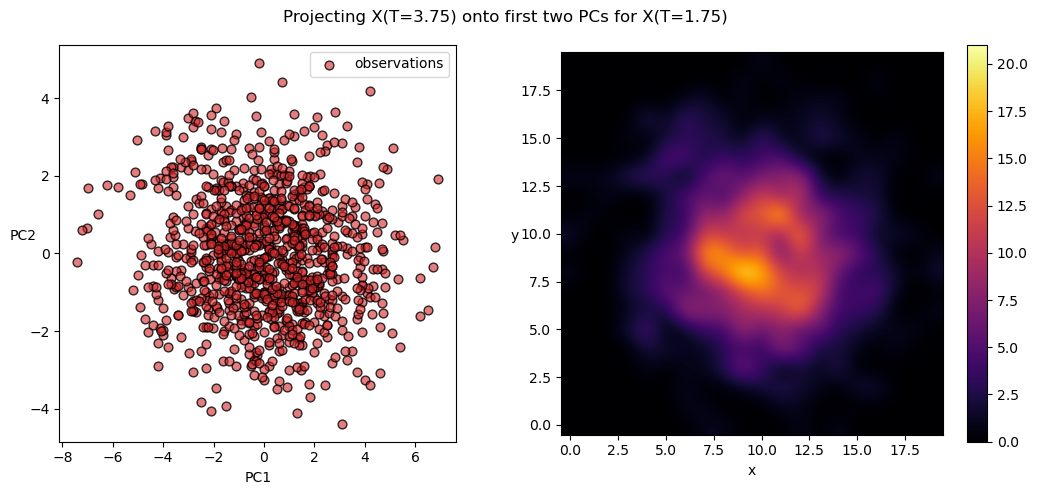

In [568]:
X_T375 = X[np.where(temp == 3.75)[0][0],:,:]
Xred2 = X_T375 @ pca.components_.T

plot_PCA_projection(Xred2, 'Projecting X(T=3.75) onto first two PCs for X(T=1.75)')

Observe that the distribution of points, particularly for the first principal component of 
the low-temperature case completely changes when we heat up the system.

Use this to speculate on what the first principal component may mainly correspond to 
(in terms of spin configurations)?

YOUR ANSWER HERE